# Barren Plateaus問題

Barren Plateau問題とは、  
量子ニューラルネットワークにおいてパラメータがランダムに初期化された場合、  
量子ビットや量子回路の深さの増加に伴い勾配が消失して学習が停滞してしまう現象のこと。

本notebookではランダムに初期化されたパラメータを持つ量子ニューラルネットワークにおいて、  
量子ビット数の増加に伴って勾配が消失することをシミュレータ上で検証する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, Gradient

# ランダム回路の生成


例としてパラメータ1つの量子回路で、そのほかはランダムに初期化されている回転ゲートを含む回路を実装する。  
計算を抑えるため適当なパラメータ一つに対しての勾配の変化を考える。

In [ ]:
def generate_random_qnn(qubits, depth):
    """Generate random QNN's with the same structure from McClean et al."""
    param = Parameter('theta')

    circuit = QuantumCircuit(qubits)
    for qubit in range(qubits):
        circuit.ry(np.pi / 4.0, qubit)

    circuit.barrier()

    for d in range(depth):
        # Add a series of single qubit rotations.
        for qubit in range(qubits):
            random_n = np.random.uniform()
            random_rot = np.random.uniform() * 2.0 * np.pi if qubit != 0 or d != 0 else param
            if random_n > 2. / 3.:
                # Add a Z.
                circuit.rz(random_rot, qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit.ry(random_rot, qubit)
            else:
                # Add a X.
                circuit.rx(random_rot, qubit)
        circuit.barrier()

        # Add CZ ladder.
        for src, dest in zip(range(qubits), range(qubits)[1:]):
            circuit.cz(src, dest)
        circuit.barrier()

    return circuit

In [ ]:
# 生成される回路の確認(例:3量子ビット)
n_qubits = 3
d = 2
qc_test = generate_random_qnn(n_qubits, d)
qc_test.draw('mpl')

In [ ]:
# 勾配の計算
def calc_gradient(qc, hamiltonian, params):
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
    state_grad = Gradient().convert(expectation)
    value_dict = dict(zip(qc.parameters, params))
    result = state_grad.assign_parameters(value_dict).eval()
    return np.round(np.array(result), 10)

In [ ]:
# # テスト勾配計算
# test_hamiltonian = PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)])
# test_params = np.random.uniform(0, np.pi, qc_test.num_parameters)
# calc_gradient(qc_test, test_hamiltonian, test_params)

# 実行
量子ビットの数が増加するにつれて勾配の分散が減少しており、勾配が消失していることがわかる。

In [ ]:
n_qubits = [2 * i for i in range(2, 7)]
depth = 30
n_circuits = 100
hamiltonian = PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)])
theta_vars = []

for n in n_qubits:
    grads = []
    # Generate the random circuits and observable for the given n.
    qc = generate_random_qnn(n, depth)
    for _ in range(n_circuits):
        params = np.random.uniform(0, np.pi, qc.num_parameters)
        grad = calc_gradient(qc, hamiltonian, params)
        grads.append(grad)
    theta_vars.append(np.var(grads))

plt.semilogy(n_qubits, theta_vars)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

# 2量子ビットを例に視覚化してみる

In [20]:
def generate_2qubit_qnn(label):
    circuit = QuantumCircuit(2)
    circuit.ry(np.pi / 4.0, 0)
    circuit.ry(np.pi / 4.0, 1)

    circuit.barrier()
    for i in range(2):
        if label[i] == 'x':
            circuit.rx(Parameter('theta'+str(i)), i)
        elif label[i] == 'y':
            circuit.ry(Parameter('theta'+str(i)), i)
        elif label[i] == 'z':
            circuit.rz(Parameter('theta'+str(i)), i) 
    circuit.barrier()

    # Add CZ ladder.
    circuit.cz(0, 1)

    return circuit

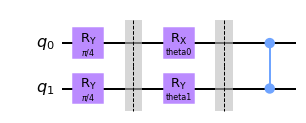

In [21]:
qc_test = generate_2qubit_qnn('xy')
qc_test.draw('mpl')

In [22]:
# 期待値の計算
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler
from qiskit.opflow.expectations import AerPauliExpectation

def calculate_exp_val(qc, hamiltonian, params):
  expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
  test_expectation = AerPauliExpectation().convert(expectation)

  quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                    shots = 32768)
  sampler = CircuitSampler(quantum_instance)

  value_dict = dict(zip(qc.parameters, params))
  result = sampler.convert(test_expectation, params=value_dict).eval()
  return np.real(result)

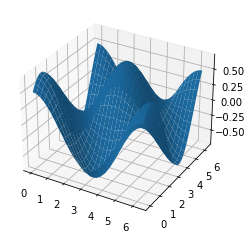

In [23]:
hamiltonian = PauliSumOp.from_list([('X', 1.0)])

X = np.linspace(0, 2*np.pi, 30)
Y = np.linspace(0, 2*np.pi, 30)
Z = np.array([[calculate_exp_val(qc_test, hamiltonian, [x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))

xx, yy = np.meshgrid(X, Y)
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(xx, yy, Z)

plt.show()

## reference

- https://www.tensorflow.org/quantum/tutorials/barren_plateaus
- https://learn.qiskit.org/course/machine-learning/training-quantum-circuits#training-48-4
- https://www.nature.com/articles/s41467-018-07090-4.pdf

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table